# Distribution
This tutorial shows how to generate the plots showing the distribution of preferred directions, as found in the paper in Fig. 6A-D

This script should be run using the libraries from the environment.yml file.

In [47]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from rowwise_neuron_curves_controls import *
import os
from scipy.stats import t
from controls_main import RunInfo

## A: Histogram of Preferred Directions

In [8]:
modelinfo = dict({'type': 'S',
            'base': 'spatial_temporal_4_8-16-16-32_64-64-64-64_5272',
            'name': 'spatial_temporal_4_8-16-16-32_64-64-64-64_5272_1',
            'shortbase': 'Spatial-Temporal',
            'shortname': 'Spatial-Temporal_1',
            'nlayers': 8,
            'max_act': 14,
            'control': False,
            'cmap': 'Blues_r',
            'color': 'C0',
            'control_cmap': 'Purples_r'})

runinfo = RunInfo({'expid': 102, #internal experiment id
                   'datafraction': 0.5,
                   'randomseed': 2000,
                   'randomseed_traintest': 42,
                   'dirr2threshold': 0.2,
                   'verbose': 0,
                   'model_experiment_id': 4, #as per Pranav's model generation
                   'basefolder' : '/home/kai/Dropbox/DeepDrawData/analysis-data/', #point to analysis-data folder
                       #in DeepDrawData folder from Dropbox, include trailing slash
                   'orientation' : 'hor',
                   'height' : 'all'
            })

specify options

In [1]:
r2threshold = 0.2 #threshold above which units are counted as being directionally tuned

In [29]:
nbins=18
nlayers = modelinfo['nlayers'] + 1
maxact = modelinfo['max_act']
fset = 'vel'
mmod = 'std'

resultsfolder = runinfo.resultsfolder(modelinfo)
prefdirfolder = runinfo.analysisfolder(modelinfo, 'prefdir')
expf = '%s%s/' %(resultsfolder, 'vel')

# READ IN ALL EVALS
alltestevals = []
alltrainevals = []

for ilayer in np.arange(0,nlayers):
    testevals = np.load('%sl%d_%s_mets_%s_%s_test.npy' %(expf, ilayer, fset, mmod, runinfo.planestring()))        
    alltestevals.append(testevals)

    trainevals = np.load('%sl%d_%s_mets_%s_%s_train.npy' %(expf, ilayer, fset, mmod, runinfo.planestring()))        
    alltrainevals.append(trainevals)

/home/kai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/kai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/home/kai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


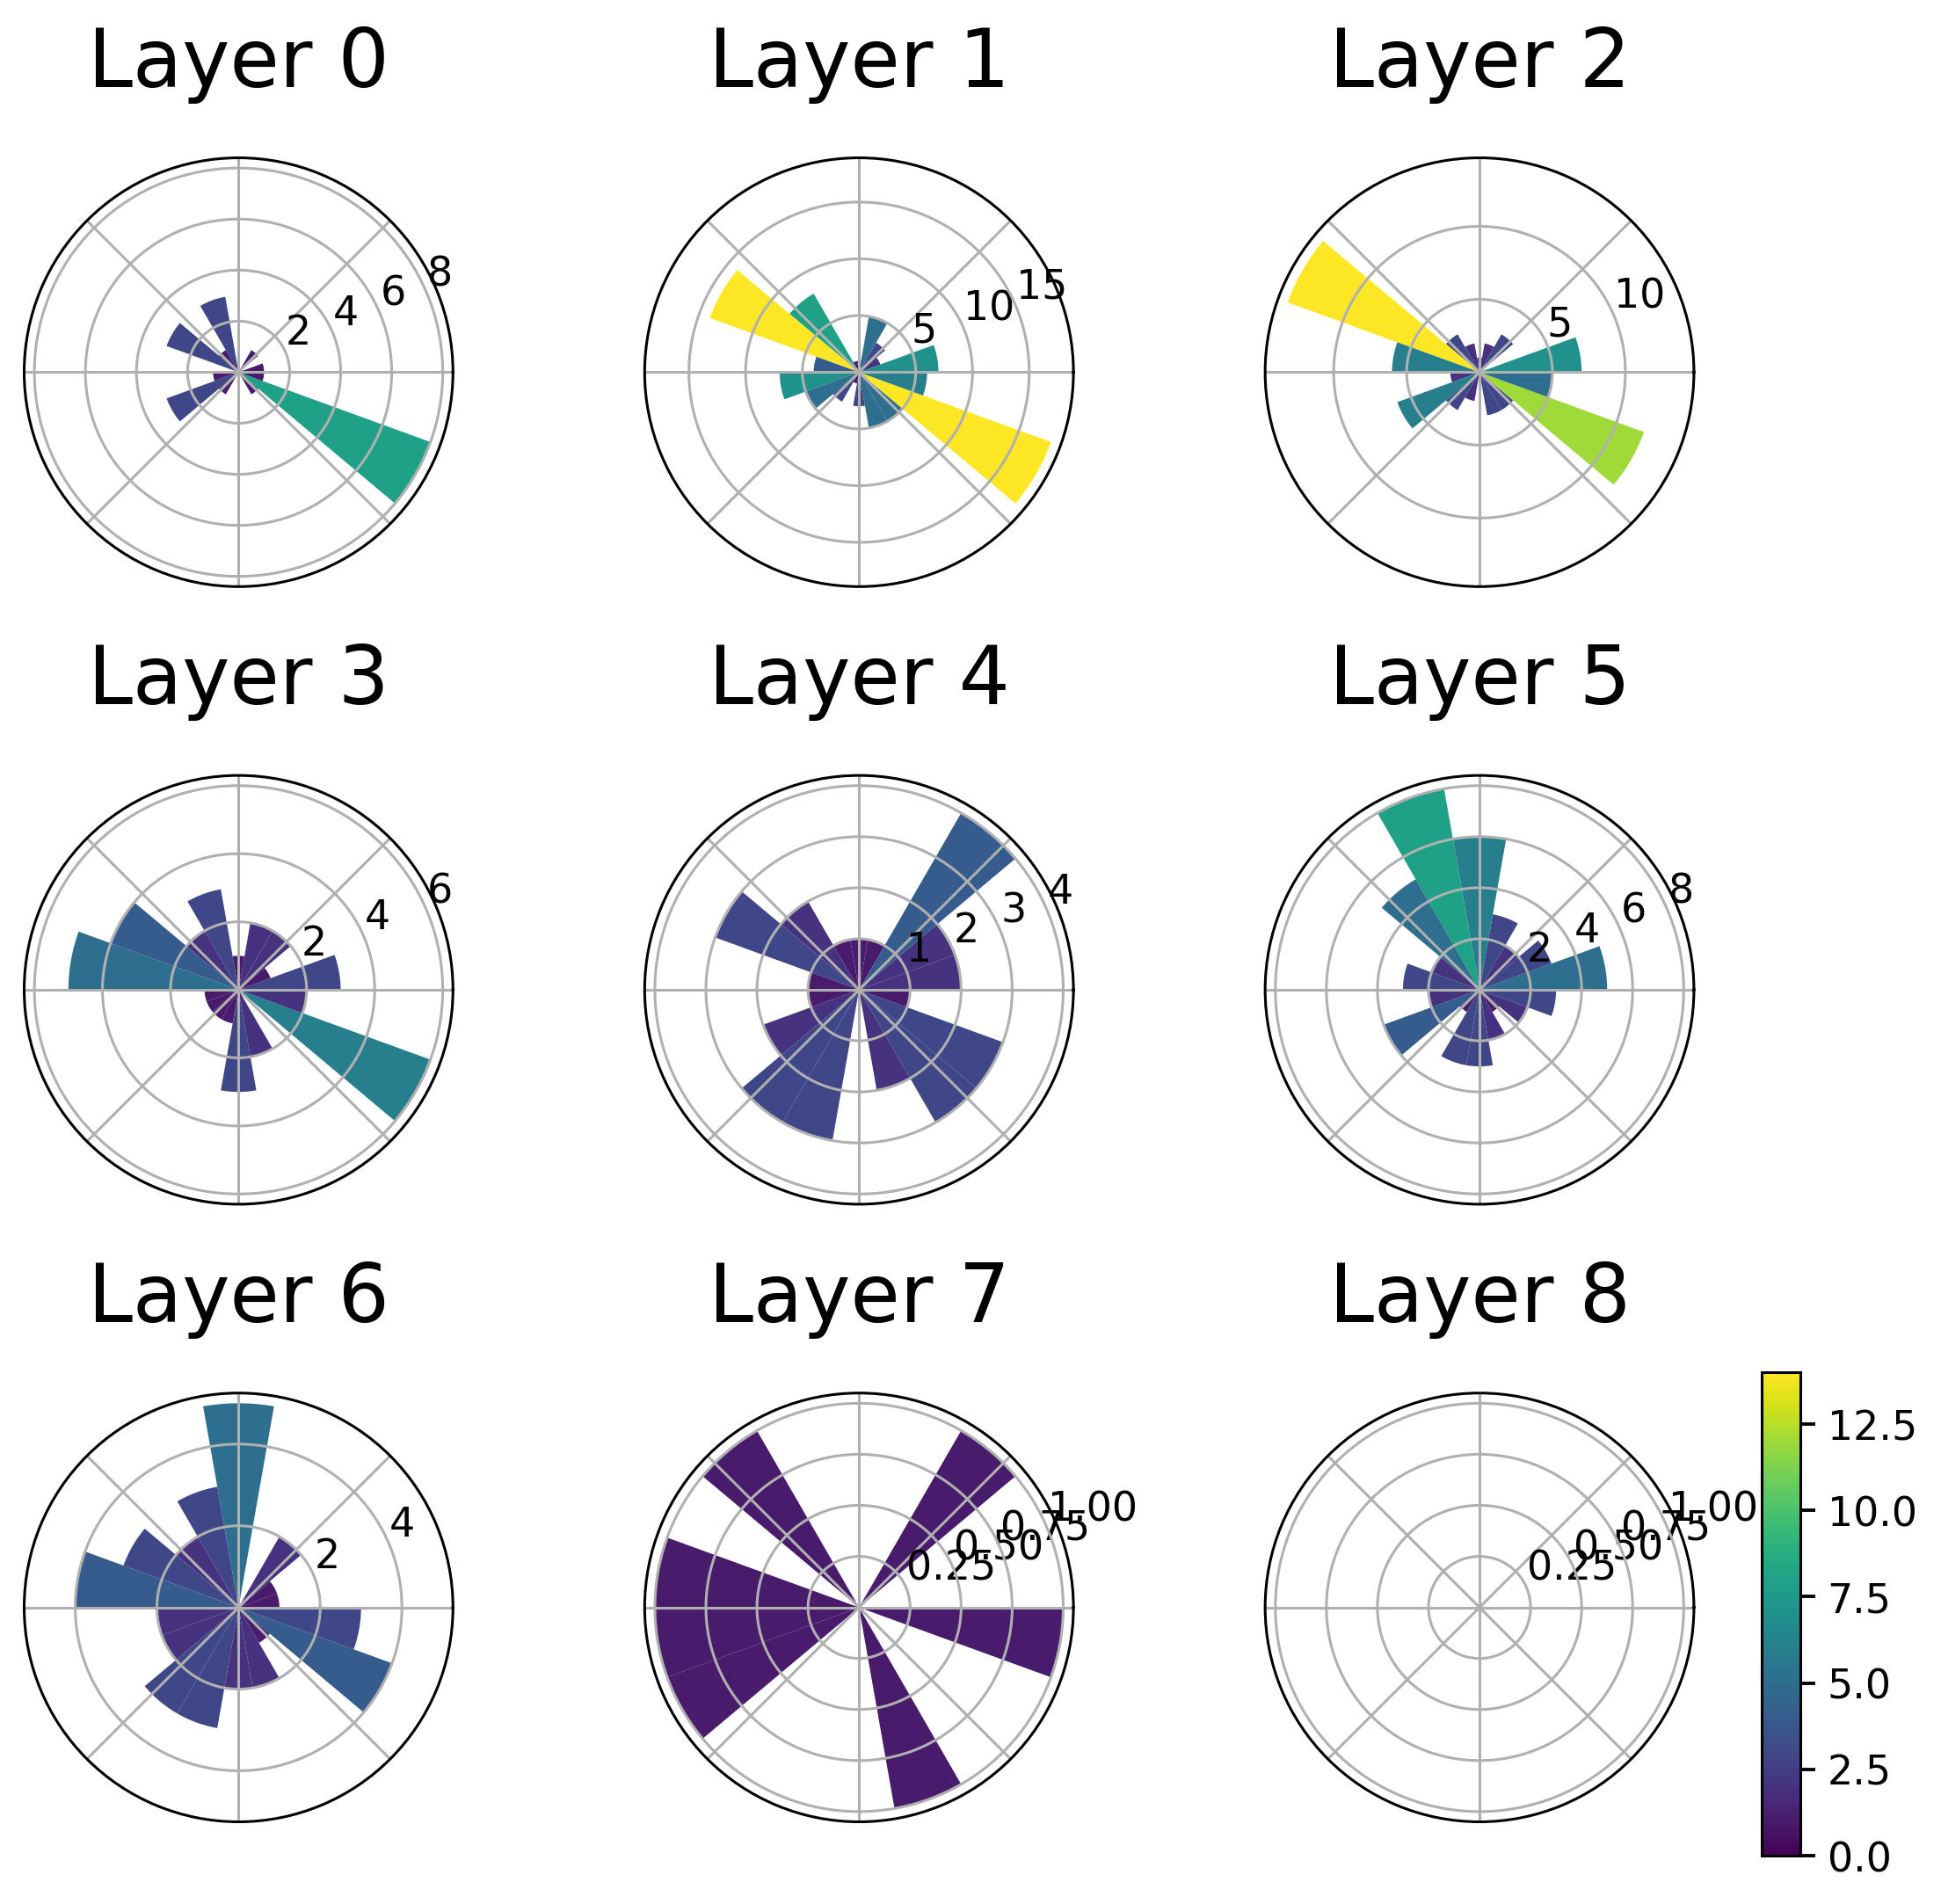

In [37]:
fig = plt.figure(dpi=275)

#COMPUTE HISTOGRAMS 

for ilayer, testevals in enumerate(alltestevals):
    #print("Layer %d" % (ilayer + 1))
    r2 = testevals[...,1,1]
    #print(r2[r2 > r2threshold].size)
    sigfit = testevals[r2 > r2threshold]
    dirtuning = sigfit[...,1,3:5].reshape((-1,2))

    if len(dirtuning) > 0:
        prefdir = np.apply_along_axis(angle_xaxis, 1, dirtuning)
    else:
        prefdir = []
        
    ax = fig.add_subplot(3, 3, ilayer + 1, projection='polar')
    if prefdir != []:
        hist, binedges = np.histogram(prefdir, bins=nbins, range=(-np.pi, np.pi))
        centers = [(binedges[i] + binedges[i + 1])/2 for i in range(nbins)]
        colors = [plt.cm.viridis(r/maxact) for r in hist]
    else:
        hist = []
        centers = []
        colors = []
    
    width = 2*np.pi/nbins
    bars = ax.bar(centers, hist, width=width, color=colors)
    ax.set_title('Layer %d' %(ilayer), pad = 15)    
    ax.set_xticklabels([])

fig.subplots_adjust(right=0.85)
cbax = fig.add_axes([0.95, 0.02, 0.02, 0.25])

cmap = matplotlib.cm.viridis
norm = matplotlib.colors.Normalize(vmin=0, vmax=maxact)

cb1 = matplotlib.colorbar.ColorbarBase(cbax, cmap=cmap,
                                norm=norm,
                                )

fig.suptitle('')
plt.tight_layout()
plt.show()

## B: Deviation from Uniformity

In [51]:
def format_axis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.xaxis.set_tick_params(size=6)
    ax.yaxis.set_tick_params(size=6)
    
    
    #ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

In [48]:
def get_pds_sp(model, runinfo, r2threshold =  None):
    """ Get pds in a single plane 
    
    Arguments
    ---------
    model : dict
    runinfo : RunInfo (extension of dict)
    r2threshold : float, threshold above which test scores mean a neuron is directionally tuned

    Returns
    -------
    pds : list [nr_layers] of np.array [height index for planes, nr_neurons]
    """
    
    nlayers = model['nlayers'] + 1 #add 1 for spindles
    
    fset = 'vel'
    mmod = 'std'
    
    
    ##SAVE PDs & R2s
    pds = []
    for ilayer in range(nlayers):
        
        resultsfolder = runinfo.resultsfolder(model)
        expf = '%s%s/' %(resultsfolder, 'vel')
        
        testevals = np.load('%sl%d_%s_mets_%s_%s_test.npy' %(expf, ilayer, fset, mmod, runinfo.planestring()))        
        if r2threshold is not None:
            testevals = testevals[testevals[...,1,1] > r2threshold] 
        if testevals.size > 0:
            dirtuning = testevals[...,1,3:5].reshape((-1,2))            
            prefdirs = np.apply_along_axis(angle_xaxis, 1, dirtuning)
        else:
            prefdirs = []
        """Create numpy for pref dirs with structure:
            Ax 1: Height Index
            Ax 2: Neurons
        """
        
        pds.append(prefdirs)
        
    return pds

In [49]:
nlayers = modelinfo['nlayers'] + 1
    
layers = ['Sp.'] + ['L%d' %i for i in np.arange(1,nlayers)]

modelbase = modelinfo['base']
trainednamer = lambda i: modelbase + '_%d' %i
controlnamer = lambda i: modelbase + '_%dr' %i
modelnames = [namer(i) for i in np.arange(1,6) for namer in (trainednamer, controlnamer)]

df = pd.DataFrame(index=modelnames, columns=layers)

trainedmodeldevs = np.empty((5, nlayers))
controlmodeldevs = np.empty((5, nlayers))

trainednames = [trainednamer(i) for i in np.arange(1,6)]
controlnames = [controlnamer(i) for i in np.arange(1,6)]

##initialize to nan
trainedmodeldevs[:] = np.nan
controlmodeldevs[:] = np.nan

imodel = 0
for mname in modelnames:
    model = modelinfo.copy()
    model['name'] = mname
    pds = get_pds_sp(model, runinfo, r2threshold = r2threshold)

    for ilayer, layer in enumerate(layers):
        layerpds = pds[ilayer]
        if (layerpds != []):
            layermask = ~np.isnan(layerpds)
            layerpds = layerpds[layermask]

            ### normalize by number of directionally tuned neurons
            ndirtuned = len(layerpds)

            hist, binedges = np.histogram(layerpds, bins=18, range=(-np.pi, np.pi))

            histmean = np.nanmean(hist)
            layerdev = np.abs(hist - histmean).sum()

            ###normalize
            if ndirtuned > 0:
                layerdev = layerdev / ndirtuned
            else:
                layerdev = np.nan

            df.loc[mname, layer] = layerdev

            if mname[-1] != 'r':
                trainedmodeldevs[imodel, ilayer] = layerdev
            else:
                controlmodeldevs[imodel, ilayer] = layerdev     

    if mname[-1] == 'r':
        imodel += 1

/home/kai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/kai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


/home/kai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  
/home/kai/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


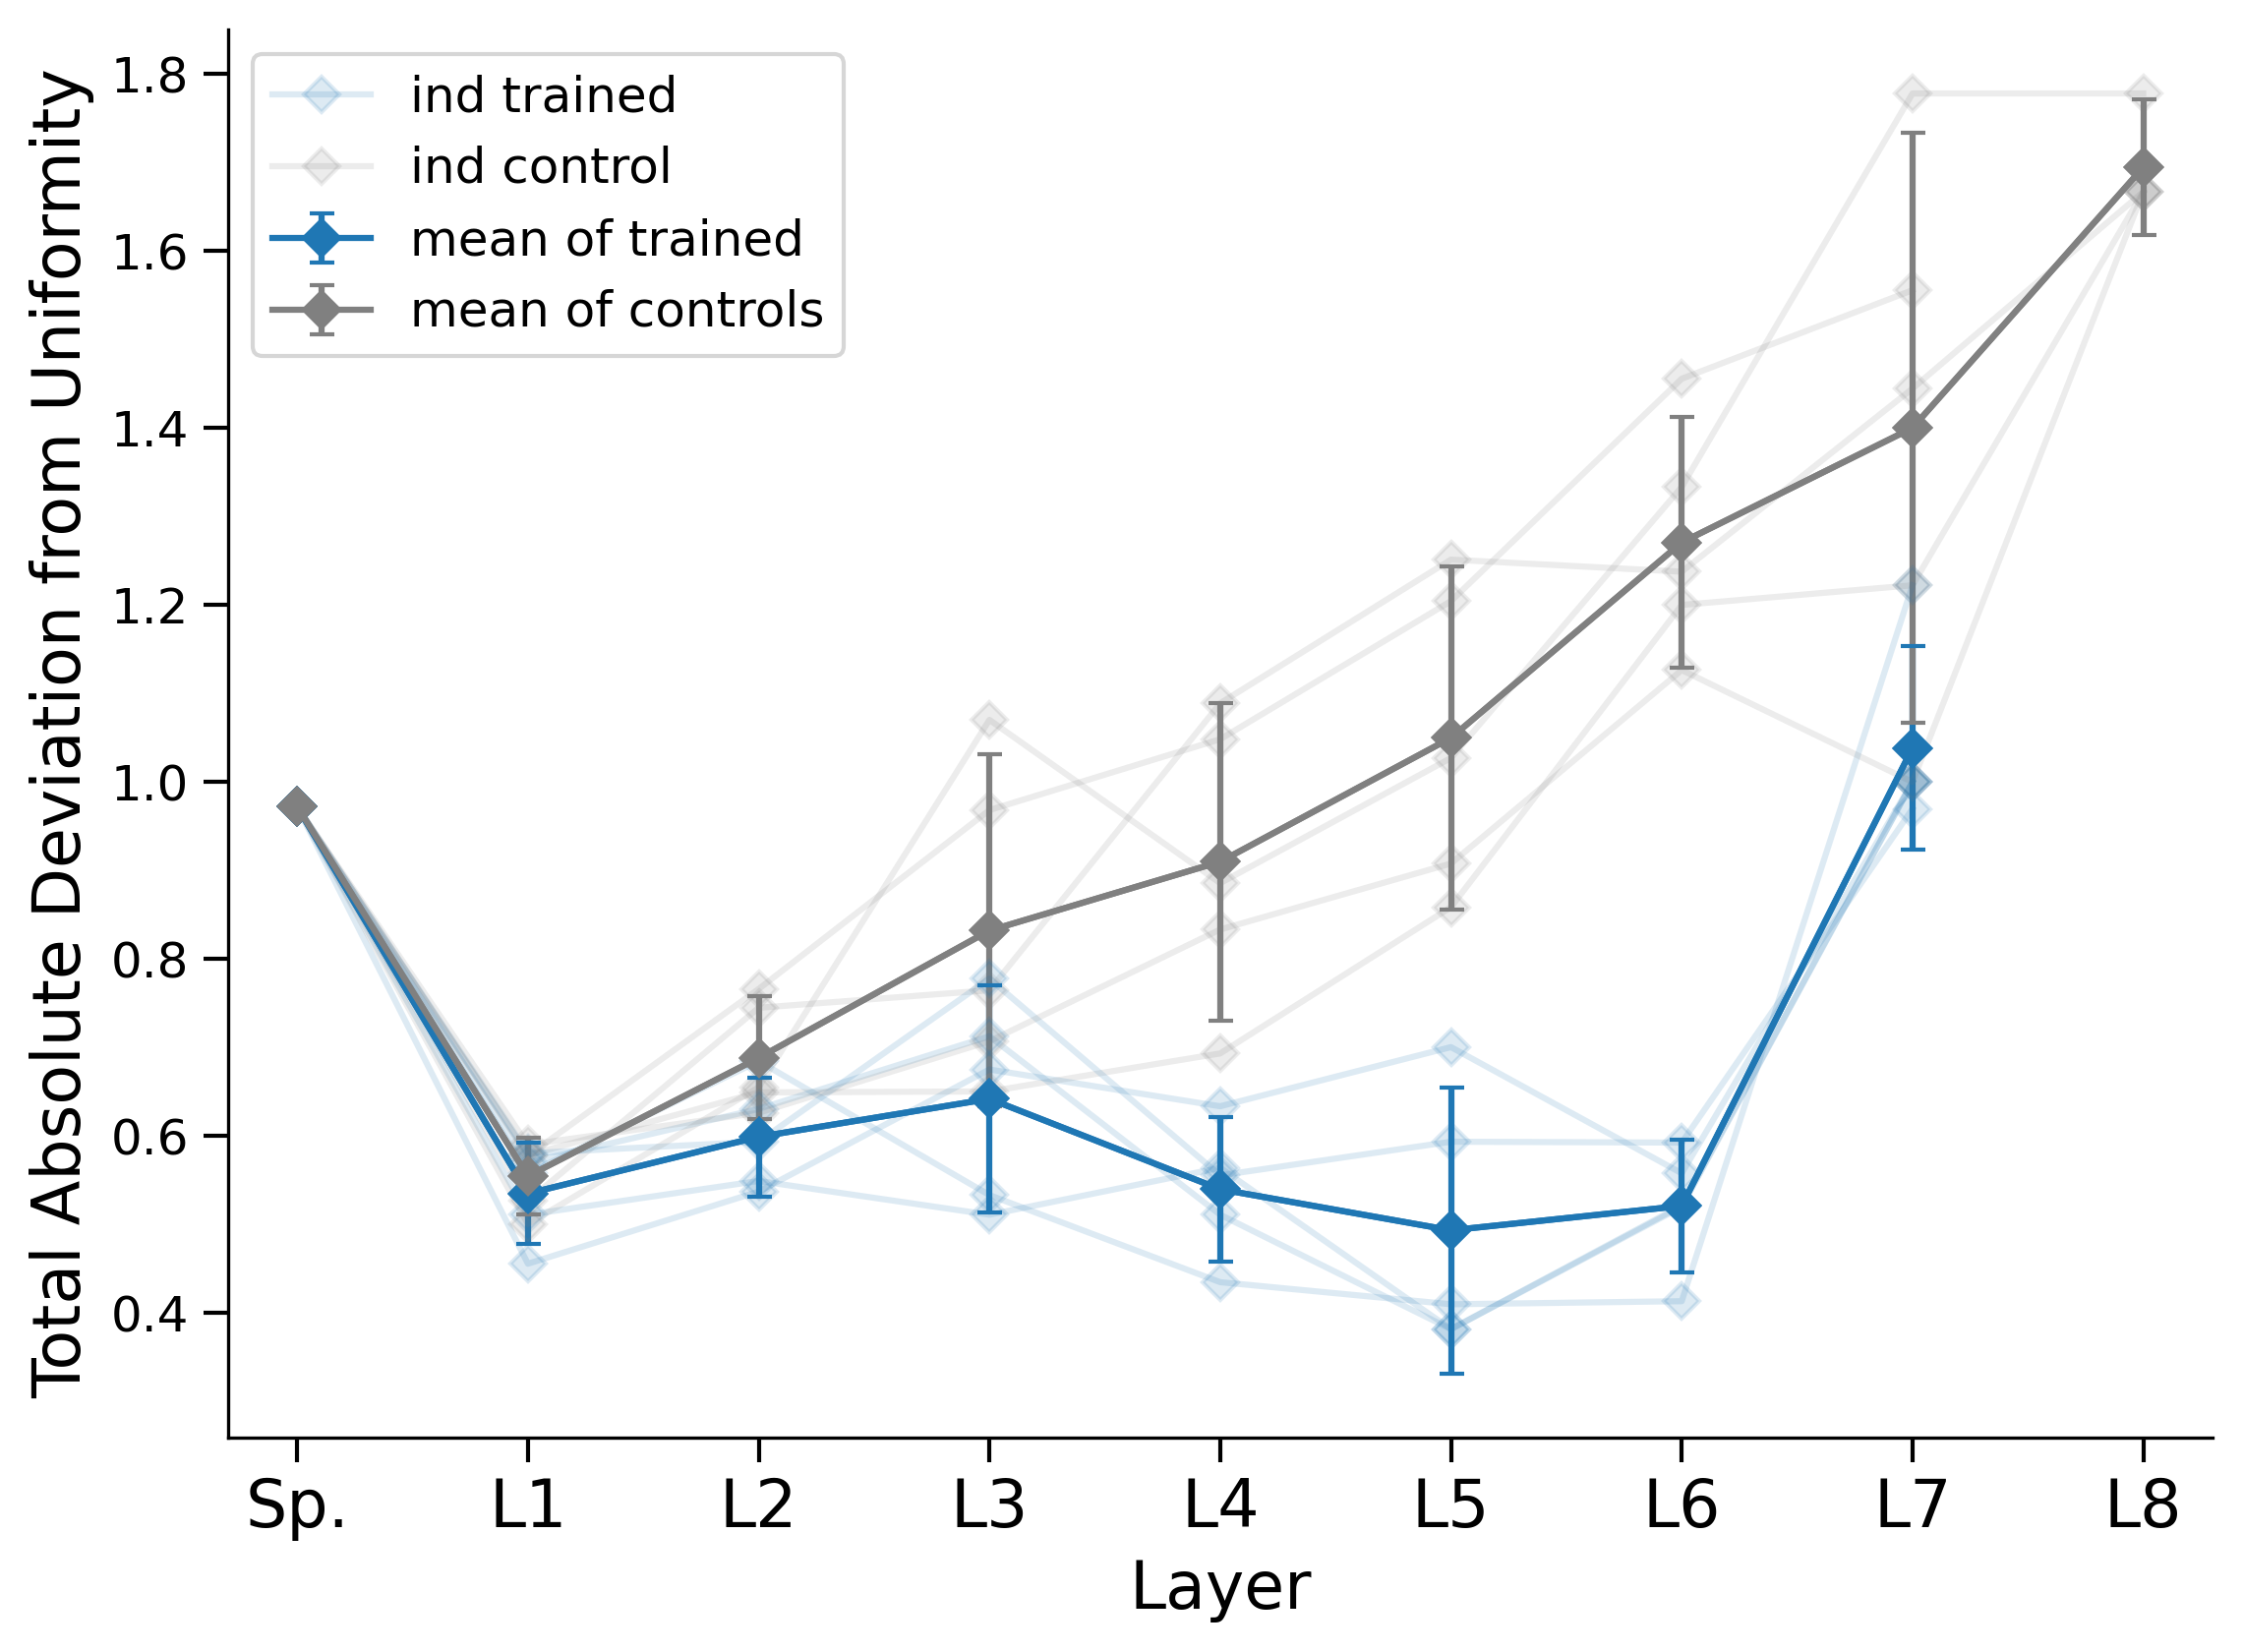

In [52]:
fig = plt.figure(figsize=(8,6),dpi=300)
ax = fig.add_subplot(111)

tmdevs = trainedmodeldevs
cmdevs = controlmodeldevs

for i in range(len(tmdevs)):
    plt.plot(range(len(layers)), tmdevs[i], color=modelinfo['color'], marker = 'D', alpha = 0.15, label='ind trained')
    plt.plot(range(len(layers)), cmdevs[i], color='grey', marker = 'D', alpha = 0.15, label='ind control')

#solution to calculate conf. interval of means from https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.t.html
#t_corr = t.ppf(0.975, 4)

tmsmean = np.nanmean(tmdevs, axis=0)    
cmsmean = np.nanmean(cmdevs, axis=0)

n_tms = np.sum(~np.isnan(tmdevs), axis=0)
n_cms = np.sum(~np.isnan(cmdevs), axis=0)

trained_t_corr = np.array([t.ppf(0.975, n - 1) for n in n_tms])
control_t_corr = np.array([t.ppf(0.975, n - 1) for n in n_cms])

errs_tmsmean = np.nanstd(tmdevs, axis=0) / np.sqrt(n_tms) * trained_t_corr
errs_cmsmean = np.nanstd(cmdevs, axis=0) / np.sqrt(n_cms) * control_t_corr

plt.plot(range(len(layers)), tmsmean, color=modelinfo['color'], marker = 'D')
plt.plot(range(len(layers)), cmsmean, color='grey', marker = 'D')

plt.errorbar(layers, tmsmean, yerr=errs_tmsmean, marker='D', color=modelinfo['color'], capsize=3.0, label='mean of trained')
plt.errorbar(layers, cmsmean, yerr=errs_cmsmean, marker = 'D', color='grey', capsize=3.0, label='mean of controls')

plt.xticks(list(range(len(layers))))
plt.xlim((-0.3, len(layers)-0.7))
plt.xlabel('Layer')
plt.ylabel('Total Absolute Deviation from Uniformity')

ax = plt.gca()
format_axis(ax)
handles, _ = ax.get_legend_handles_labels()
handles = np.array(handles)

plt.legend(handles[[0,1,10,11]], ['ind trained', 'ind control', \
            'mean of trained', 'mean of controls'])

plt.tight_layout()